# Imports and Data

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize

import time

In [42]:
device = 'cpu'

In [43]:
X_train = np.load('X-IIoT-pre-processed/x_train.npy')
y_train = np.load('X-IIoT-pre-processed/y_train.npy')
X_val = np.load('X-IIoT-pre-processed/X_val.npy')
y_val = np.load('X-IIoT-pre-processed/y_val.npy')
X_test = np.load('X-IIoT-pre-processed/X_test.npy')
y_test = np.load('X-IIoT-pre-processed/y_test.npy')

# Deep Neural Network

Parameters:
4 hidden layers (relu), 200 neurons each, batch=100, epoch=100, optimizer=Adam, lr=0.001, earlyStop={patience:10,delta:0.001}

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [99]:
class DNNMulticlass(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(58, 200) # 58 features => len(X_train[0])
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, 200)
        self.layer4 = nn.Linear(200, 200)
        self.out_layer = nn.Linear(200, 19) # 19 classifications =>  np.unique(y_train)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.out_layer(x) 
        return x

In [100]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [109]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)

y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=100)

In [110]:
# Training

start_time = time.time()

model_dnn = DNNMulticlass().to(device)
early_stopping = EarlyStopping(patience=10, delta=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001)

training_losses = []
validation_losses = []

epochs = 100
for epoch in range(epochs): # Epochs/steps
    model_dnn.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Feed forward + backpropogate
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Validation
    model_dnn.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        # Average validation loss for this epoch
        avg_val_loss = val_loss / len(test_loader)
        validation_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


print('Finished Training')

training_time = time.time() - start_time
print(f"Training time: {training_time}")

Epoch [1/100], Training Loss: 0.1890, Validation Loss: 0.1339
Epoch [2/100], Training Loss: 0.0982, Validation Loss: 0.1214
Epoch [3/100], Training Loss: 0.0833, Validation Loss: 0.0759
Epoch [4/100], Training Loss: 0.0742, Validation Loss: 0.0825
Epoch [5/100], Training Loss: 0.0687, Validation Loss: 0.0692
Epoch [6/100], Training Loss: 0.0656, Validation Loss: 0.0873
Epoch [7/100], Training Loss: 0.0626, Validation Loss: 0.0590
Epoch [8/100], Training Loss: 0.0606, Validation Loss: 0.0713
Epoch [9/100], Training Loss: 0.0585, Validation Loss: 0.0591
Epoch [10/100], Training Loss: 0.0579, Validation Loss: 0.0540
Epoch [11/100], Training Loss: 0.0563, Validation Loss: 0.0592
Epoch [12/100], Training Loss: 0.0551, Validation Loss: 0.0531
Epoch [13/100], Training Loss: 0.0537, Validation Loss: 0.0538
Epoch [14/100], Training Loss: 0.0531, Validation Loss: 0.0558
Epoch [15/100], Training Loss: 0.0526, Validation Loss: 0.1058
Epoch [16/100], Training Loss: 0.0520, Validation Loss: 0.0499
E

In [111]:
model_dnn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dnn(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [112]:
cm = confusion_matrix(all_labels, all_preds)

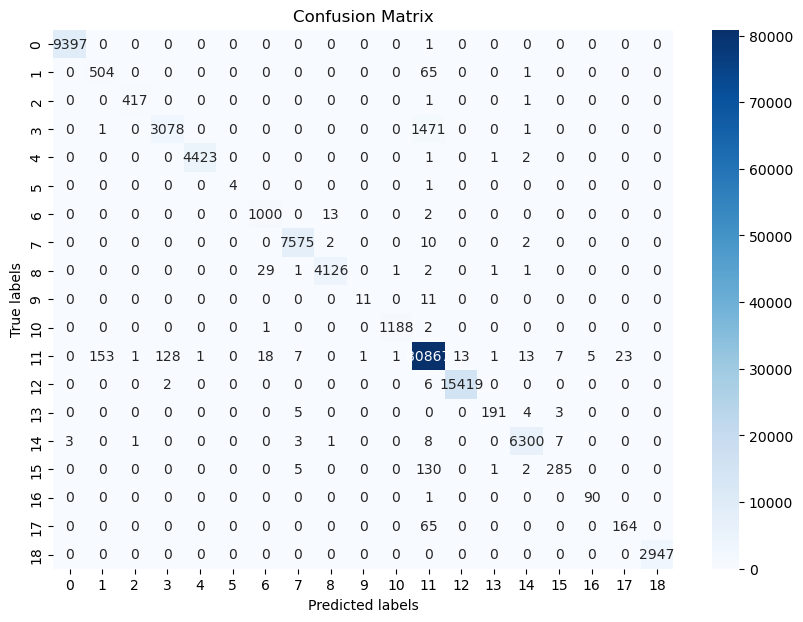

In [113]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

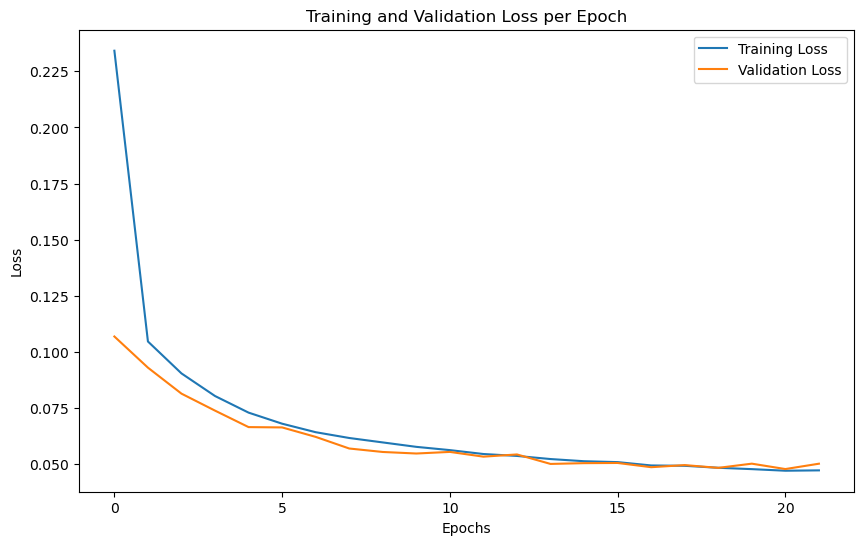

In [95]:
# Get the training and validation graphs

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metrics (No Attacks)

### Helpers

In [80]:
def calculate_weighted_rates(cm):
    num_classes = cm.shape[0]
    total_instances = np.sum(cm)
    
    weighted_TPR = 0
    weighted_TNR = 0
    weighted_FPR = 0
    weighted_FNR = 0
    
    for class_index in range(num_classes):
        TP = cm[class_index, class_index]
        FP = cm[:, class_index].sum() - TP
        FN = cm[class_index, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        
        class_size = cm[class_index, :].sum()  # Total true instances for the class
        
        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        TNR = TN / (TN + FP) if (TN + FP) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        FNR = FN / (FN + TP) if (FN + TP) != 0 else 0
        
        weighted_TPR += (class_size / total_instances) * TPR
        weighted_TNR += (class_size / total_instances) * TNR
        weighted_FPR += (class_size / total_instances) * FPR
        weighted_FNR += (class_size / total_instances) * FNR

    return weighted_TPR, weighted_TNR, weighted_FPR, weighted_FNR

def metrics_weighted(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(labels_binarized, probabilities, average='weighted', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)
    
    TPR, TNR, FPR, FNR = calculate_weighted_rates(cm)

    print(f'Accuracy (Weighted): {accuracy:.4f}')
    print(f'Precision (Weighted): {precision:.4f}')
    print(f'Recall (Weighted): {recall:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    print(f'AUC (Weighted): {auc:.4f}')
    print(f'TPR (Weighted): {TPR:.4f}')
    print(f'TNR (Weighted): {TNR:.4f}')
    print(f'FPR (Weighted): {FPR:.4f}')
    print(f'FNR (Weighted): {FNR:.4f}')

In [83]:
def calculate_class_metrics_macro(cm, class_index):
    TP = cm[class_index, class_index]
    FP = cm[:, class_index].sum() - TP
    FN = cm[class_index, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0  
    FNR = FN / (FN + TP) if (FN + TP) != 0 else 0  
    
    return TPR, TNR, FPR, FNR

def metrics_macro(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), probabilities, average='macro', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)

    # Calculate metrics for each class and take the average
    metrics = np.array([calculate_class_metrics_macro(cm, i) for i in range(num_classes)])
    TPR_macro, TNR_macro, FPR_macro, FNR_macro = np.mean(metrics, axis=0)

    print(f'Accuracy (Macro): {accuracy:.4f}')
    print(f'Precision (Macro): {precision:.4f}')
    print(f'Recall (Macro): {recall:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')
    print(f'AUC (Macro): {auc:.4f}')
    print(f'TPR (Macro): {TPR_macro:.4f}')
    print(f'TNR (Macro): {TNR_macro:.4f}')
    print(f'FPR (Macro): {FPR_macro:.4f}')
    print(f'FNR (Macro): {FNR_macro:.4f}')

In [89]:
def calculate_metrics_micro(cm):
    TP_sum = np.sum(np.diag(cm))  # Sum of True Positives
    FP_sum = np.sum(cm) - TP_sum  # Sum of False Positives (total minus TP)
    FN_sum = FP_sum  # In micro-averaging for multi-class, FN and FP are equivalent in sum
    TN_sum = np.sum(cm) * (cm.shape[0] - 1) - 2 * FP_sum  # Adjusting TN for multi-class
    
    TPR_micro = TP_sum / (TP_sum + FN_sum) if (TP_sum + FN_sum) != 0 else 0
    TNR_micro = TN_sum / (TN_sum + FP_sum) if (TN_sum + FP_sum) != 0 else 0
    FPR_micro = FP_sum / (FP_sum + TN_sum) if (FP_sum + TN_sum) != 0 else 0
    FNR_micro = FN_sum / (FN_sum + TP_sum) if (FN_sum + TP_sum) != 0 else 0
    
    return TPR_micro, TNR_micro, FPR_micro, FNR_micro

def metrics_micro(model, test_load, num_classes, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    probabilities = np.array(probabilities)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), probabilities, average='micro', multi_class='ovr')

    cm = confusion_matrix(all_labels, all_preds)
    TPR_micro, TNR_micro, FPR_micro, FNR_micro = calculate_metrics_micro(cm)

    print(f'Accuracy (Micro): {accuracy:.4f}')
    print(f'Precision (Micro): {precision:.4f}')
    print(f'Recall (Micro): {recall:.4f}')
    print(f'F1 Score (Micro): {f1:.4f}')
    print(f'AUC (Micro): {auc:.4f}')
    print(f'TPR (Micro): {TPR_micro:.4f}')
    print(f'TNR (Micro): {TNR_micro:.4f}')
    print(f'FPR (Micro): {FPR_micro:.4f}')
    print(f'FNR (Micro): {FNR_micro:.4f}')


## Evaluations

### DNN on normal samples

In [114]:
metrics_weighted(model_dnn, test_loader, 19, 'cpu')

Accuracy (Weighted): 0.9840
Precision (Weighted): 0.9839
Recall (Weighted): 0.9840
F1 Score (Weighted): 0.9830
AUC (Weighted): 0.9989
TPR (Weighted): 0.9840
TNR (Weighted): 0.9825
FPR (Weighted): 0.0175
FNR (Weighted): 0.0160


In [115]:
metrics_macro(model_dnn, test_loader, 19, 'cpu')

Accuracy (Macro): 0.9840
Precision (Macro): 0.9633
Recall (Macro): 0.9020
F1 Score (Macro): 0.9257
AUC (Macro): 0.9991
TPR (Macro): 0.9020
TNR (Macro): 0.9982
FPR (Macro): 0.0018
FNR (Macro): 0.0980


In [116]:
metrics_micro(model_dnn, test_loader, 19, 'cpu')

Accuracy (Micro): 0.9840
Precision (Micro): 0.9840
Recall (Micro): 0.9840
F1 Score (Micro): 0.9840
AUC (Micro): 0.9999
TPR (Micro): 0.9840
TNR (Micro): 0.9991
FPR (Micro): 0.0009
FNR (Micro): 0.0160


# Adversarial Attacks

In [119]:
from art.estimators.classification import PyTorchClassifier

In [124]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## Helpers

In [169]:
def metrics_weighted_adv(predictions_adv, y_test, predictions_adv_proba, num_classes):
    
    # Reshape
    y_true = y_test
    y_pred_adv = np.argmax(predictions_adv, axis=1)

    precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_true, y_pred_adv, average='weighted')
    accuracy_adv = accuracy_score(y_true, y_pred_adv)
    
    # TPR, TNR, FPR, FNR
    cm_adv = confusion_matrix(y_true, y_pred_adv)
    
    TPR_adv, TNR_adv, FPR_adv, FNR_adv = calculate_weighted_rates(cm_adv)
    
    # AUC
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))
    auc_adv = roc_auc_score(y_test_binarized, predictions_adv_proba, average='weighted', multi_class='ovr')
    
    print("Weighted")
    
    print(f"Adv Acc: {accuracy_adv:.4f}")
    print(f"Adv Prec: {precision_adv:.4f}")
    print(f"Adv Rec: {recall_adv:.4f}")
    print(f"Adv F1: {f1_adv:.4f}")
    
    print(f"Adv TPR: {TPR_adv:.4f}") 
    print(f"Adv TNR: {TNR_adv:.4f}") 
    print(f"Adv FPR: {FPR_adv:.4f}")
    print(f"Adv FNR: {FNR_adv:.4f}")
    
    print(f"Adv AUC: {auc_adv:.4f}")

In [167]:
def metrics_macro_adv(predictions_adv, y_test, predictions_adv_proba, num_classes):
    y_true = y_test
 
    y_pred_adv = np.argmax(predictions_adv, axis=1)

    # Acc, Prec, Rec, F1
    precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_true, y_pred_adv, average='macro')
    accuracy_adv = accuracy_score(y_true, y_pred_adv)
    
    cm_adv = confusion_matrix(y_true, y_pred_adv)
    
    # TPR, TNR, FPR, FNR
    TPR_adv, TNR_adv, FPR_adv, FNR_adv = np.mean([calculate_class_metrics_macro(cm_adv, i) for i in range(10)], axis=0)
    
    # Prepare y_test for AUC calculation 
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

    # AUC
    auc_adv = roc_auc_score(y_test_binarized, predictions_adv_proba, average='macro', multi_class='ovr')
    
    print("Macro")
    
    print(f"Adv Acc: {accuracy_adv:.4f}")
    print(f"Adv Prec: {precision_adv:.4f}")
    print(f"Adv Rec: {recall_adv:.4f}")
    print(f"Adv F1: {f1_adv:.4f}")
    
    print(f"Adv TPR: {TPR_adv:.4f}") 
    print(f"Adv TNR: {TNR_adv:.4f}") 
    print(f"Adv FPR: {FPR_adv:.4f}")
    print(f"Adv FNR: {FNR_adv:.4f}")
    
    print(f"Adv AUC: {auc_adv:.4f}")

In [161]:
def metrics_micro_adv(predictions_adv, y_test, predictions_adv_proba, num_classes):
    y_true = y_test
    y_pred_adv = np.argmax(predictions_adv, axis=1)

    # Acc, Prec, Rec, F1
    precision_adv, recall_adv, f1_adv, _ = precision_recall_fscore_support(y_true, y_pred_adv, average='micro')
    accuracy_adv = accuracy_score(y_true, y_pred_adv)
    
    # TPR, TNR, FPR, FNR
    cm_adv = confusion_matrix(y_true, y_pred_adv)
    TPR_adv, TNR_adv, FPR_adv, FNR_adv = calculate_metrics_micro(cm_adv)
    
    # Prepare y_test for AUC calculation
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

    # AUC
    auc_adv = roc_auc_score(y_test_binarized, predictions_adv_proba, average='micro')
    
    print("Micro")
    
    print(f"Adv Acc: {accuracy_adv:.4f}")
    print(f"Adv Prec: {precision_adv:.4f}")
    print(f"Adv Rec: {recall_adv:.4f}")
    print(f"Adv F1: {f1_adv:.4f}")
    
    print(f"Adv TPR: {TPR_adv:.4f}") 
    print(f"Adv TNR: {TNR_adv:.4f}") 
    print(f"Adv FPR: {FPR_adv:.4f}")
    print(f"Adv FNR: {FNR_adv:.4f}")
    
    print(f"Adv AUC: {auc_adv:.4f}")

## FGSM

In [120]:
from art.attacks.evasion import FastGradientMethod

In [145]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-4, 4), # 4 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=250, nb_epochs=20)
    
    # Prediction on perturbated samples
    attack = FastGradientMethod(estimator=classifier, eps=0.3)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [147]:
model = DNNMulticlass()
predictions_adv_fgsm, predictions_adv_proba_fgsm = train(model)

Accuracy on adversarial test examples: 23.83%
Time: 66.02 seconds


In [172]:
metrics_weighted_adv(predictions_adv_fgsm, y_test, predictions_adv_proba_fgsm, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.2383
Adv Prec: 0.3185
Adv Rec: 0.2383
Adv F1: 0.2622
Adv TPR: 0.2383
Adv TNR: 0.6216
Adv FPR: 0.3784
Adv FNR: 0.7617
Adv AUC: 0.3992


In [168]:
metrics_macro_adv(predictions_adv_fgsm, y_test, predictions_adv_proba_fgsm, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.2383
Adv Prec: 0.1814
Adv Rec: 0.1028
Adv F1: 0.0932
Adv TPR: 0.1255
Adv TNR: 0.9848
Adv FPR: 0.0152
Adv FNR: 0.8745
Adv AUC: 0.4877


In [163]:
metrics_micro_adv(predictions_adv_fgsm, y_test, predictions_adv_proba_fgsm, 19)

Micro
Adv Acc: 0.2383
Adv Prec: 0.2383
Adv Rec: 0.2383
Adv F1: 0.2383
Adv TPR: 0.2383
Adv TNR: 0.9558
Adv FPR: 0.0442
Adv FNR: 0.7617
Adv AUC: 0.6669


## PGD

In [175]:
from art.attacks.evasion import ProjectedGradientDescent

In [192]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = ProjectedGradientDescent(estimator=classifier, eps=0.3)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [193]:
model = DNNMulticlass()
predictions_adv_pgd, predictions_adv_proba_pgd = train(model)

PGD - Batches:   0%|          | 0/4383 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 5.58%
Time: 169.02 seconds


In [194]:
metrics_weighted_adv(predictions_adv_pgd, y_test, predictions_adv_proba_pgd, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.0558
Adv Prec: 0.2851
Adv Rec: 0.0558
Adv F1: 0.0730
Adv TPR: 0.0558
Adv TNR: 0.8143
Adv FPR: 0.1857
Adv FNR: 0.9442
Adv AUC: 0.4628


In [195]:
metrics_macro_adv(predictions_adv_pgd, y_test, predictions_adv_proba_pgd, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.0558
Adv Prec: 0.0789
Adv Rec: 0.0429
Adv F1: 0.0116
Adv TPR: 0.0676
Adv TNR: 0.9320
Adv FPR: 0.0680
Adv FNR: 0.9324
Adv AUC: 0.4431


In [196]:
metrics_micro_adv(predictions_adv_pgd, y_test, predictions_adv_proba_pgd, 19)

Micro
Adv Acc: 0.0558
Adv Prec: 0.0558
Adv Rec: 0.0558
Adv F1: 0.0558
Adv TPR: 0.0558
Adv TNR: 0.9446
Adv FPR: 0.0554
Adv FNR: 0.9442
Adv AUC: 0.5358


## BIM

In [181]:
from art.attacks.evasion import BasicIterativeMethod

In [190]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = BasicIterativeMethod(estimator=classifier, eps=0.3)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [191]:
model = DNNMulticlass()
predictions_adv_bim, predictions_adv_proba_bim = train(model)

PGD - Batches:   0%|          | 0/4383 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 14.67%
Time: 167.32 seconds


In [201]:
metrics_weighted_adv(predictions_adv_bim, y_test, predictions_adv_proba_bim, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.1467
Adv Prec: 0.2068
Adv Rec: 0.1467
Adv F1: 0.1699
Adv TPR: 0.1467
Adv TNR: 0.6059
Adv FPR: 0.3941
Adv FNR: 0.8533
Adv AUC: 0.3682


In [202]:
metrics_macro_adv(predictions_adv_bim, y_test, predictions_adv_proba_bim, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.1467
Adv Prec: 0.0406
Adv Rec: 0.0723
Adv F1: 0.0425
Adv TPR: 0.0259
Adv TNR: 0.9694
Adv FPR: 0.0306
Adv FNR: 0.9741
Adv AUC: 0.5072


In [203]:
metrics_micro_adv(predictions_adv_bim, y_test, predictions_adv_proba_bim, 19)

Micro
Adv Acc: 0.1467
Adv Prec: 0.1467
Adv Rec: 0.1467
Adv F1: 0.1467
Adv TPR: 0.1467
Adv TNR: 0.9502
Adv FPR: 0.0498
Adv FNR: 0.8533
Adv AUC: 0.5548


## JSM

In [199]:
from art.attacks.evasion import SaliencyMapMethod

In [207]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = SaliencyMapMethod(classifier=classifier, theta=0.3, batch_size=250)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [208]:
model = DNNMulticlass()
predictions_adv_jsm, predictions_adv_proba_jsm = train(model)

JSMA:   0%|          | 0/561 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.73%
Time: 1301.88 seconds


In [209]:
metrics_weighted_adv(predictions_adv_jsm, y_test, predictions_adv_proba_jsm, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.0173
Adv Prec: 0.0005
Adv Rec: 0.0173
Adv F1: 0.0009
Adv TPR: 0.0173
Adv TNR: 0.9803
Adv FPR: 0.0197
Adv FNR: 0.9827
Adv AUC: 0.4602


In [210]:
metrics_macro_adv(predictions_adv_jsm, y_test, predictions_adv_proba_jsm, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.0173
Adv Prec: 0.0013
Adv Rec: 0.0455
Adv F1: 0.0024
Adv TPR: 0.0000
Adv TNR: 0.9892
Adv FPR: 0.0108
Adv FNR: 1.0000
Adv AUC: 0.4963


In [211]:
metrics_micro_adv(predictions_adv_jsm, y_test, predictions_adv_proba_jsm, 19)

Micro
Adv Acc: 0.0173
Adv Prec: 0.0173
Adv Rec: 0.0173
Adv F1: 0.0173
Adv TPR: 0.0173
Adv TNR: 0.9423
Adv FPR: 0.0577
Adv FNR: 0.9827
Adv AUC: 0.4618


## DF

In [213]:
from art.attacks.evasion import DeepFool

In [214]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = DeepFool(classifier=classifier, max_iter=10)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [215]:
model = DNNMulticlass()
predictions_adv_df, predictions_adv_proba_df = train(model)

DeepFool:   0%|          | 0/140230 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 2.36%
Time: 1382.17 seconds


In [234]:
metrics_weighted_adv(predictions_adv_df, y_test, predictions_adv_proba_df, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.0236
Adv Prec: 0.0281
Adv Rec: 0.0236
Adv F1: 0.0217
Adv TPR: 0.0236
Adv TNR: 0.6452
Adv FPR: 0.3548
Adv FNR: 0.9764
Adv AUC: 0.3118


In [235]:
metrics_macro_adv(predictions_adv_df, y_test, predictions_adv_proba_df, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.0236
Adv Prec: 0.0741
Adv Rec: 0.0461
Adv F1: 0.0427
Adv TPR: 0.0426
Adv TNR: 0.9306
Adv FPR: 0.0694
Adv FNR: 0.9574
Adv AUC: 0.5474


In [236]:
metrics_micro_adv(predictions_adv_df, y_test, predictions_adv_proba_df, 19)

Micro
Adv Acc: 0.0236
Adv Prec: 0.0236
Adv Rec: 0.0236
Adv F1: 0.0236
Adv TPR: 0.0236
Adv TNR: 0.9426
Adv FPR: 0.0574
Adv FNR: 0.9764
Adv AUC: 0.5928


## C&W (L_2)

In [216]:
from art.attacks.evasion import CarliniL2Method

In [218]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = CarliniL2Method(classifier=classifier, max_iter=10)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [219]:
model = DNNMulticlass()
predictions_adv_cw_l2, predictions_adv_proba_cw_l2 = train(model)

C&W L_2:   0%|          | 0/140230 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 3.20%
Time: 14110.55 seconds


In [231]:
metrics_weighted_adv(predictions_adv_cw_l2, y_test, predictions_adv_proba_cw_l2, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.0320
Adv Prec: 0.0341
Adv Rec: 0.0320
Adv F1: 0.0197
Adv TPR: 0.0320
Adv TNR: 0.7668
Adv FPR: 0.2332
Adv FNR: 0.9680
Adv AUC: 0.6776


In [232]:
metrics_macro_adv(predictions_adv_cw_l2, y_test, predictions_adv_proba_cw_l2, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.0320
Adv Prec: 0.0541
Adv Rec: 0.1242
Adv F1: 0.0468
Adv TPR: 0.0833
Adv TNR: 0.9544
Adv FPR: 0.0456
Adv FNR: 0.9167
Adv AUC: 0.8592


In [233]:
metrics_micro_adv(predictions_adv_cw_l2, y_test, predictions_adv_proba_cw_l2, 19)

Micro
Adv Acc: 0.0320
Adv Prec: 0.0320
Adv Rec: 0.0320
Adv F1: 0.0320
Adv TPR: 0.0320
Adv TNR: 0.9432
Adv FPR: 0.0568
Adv FNR: 0.9680
Adv AUC: 0.8990


## C&W (L_inf)

In [217]:
from art.attacks.evasion import CarliniLInfMethod

In [220]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = CarliniLInfMethod(classifier=classifier, max_iter=5)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [221]:
model = DNNMulticlass()
predictions_adv_cw_linf, predictions_adv_proba_cw_linf = train(model)

C&W L_inf:   0%|          | 0/140230 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 14.66%
Time: 12045.47 seconds


In [225]:
metrics_weighted_adv(predictions_adv_cw_linf, y_test, predictions_adv_proba_cw_linf, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.1466
Adv Prec: 0.2512
Adv Rec: 0.1466
Adv F1: 0.1744
Adv TPR: 0.1466
Adv TNR: 0.7279
Adv FPR: 0.2721
Adv FNR: 0.8534
Adv AUC: 0.4891


In [226]:
metrics_macro_adv(predictions_adv_cw_linf, y_test, predictions_adv_proba_cw_linf, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.1466
Adv Prec: 0.0461
Adv Rec: 0.1397
Adv F1: 0.0359
Adv TPR: 0.1245
Adv TNR: 0.9824
Adv FPR: 0.0176
Adv FNR: 0.8755
Adv AUC: 0.6040


In [227]:
metrics_micro_adv(predictions_adv_cw_linf, y_test, predictions_adv_proba_cw_linf, 19)

Micro
Adv Acc: 0.1466
Adv Prec: 0.1466
Adv Rec: 0.1466
Adv F1: 0.1466
Adv TPR: 0.1466
Adv TNR: 0.9502
Adv FPR: 0.0498
Adv FNR: 0.8534
Adv AUC: 0.7057


## EN

In [222]:
from art.attacks.evasion import ElasticNet

In [223]:
def train(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(-5, 5), # 5 std devs each direction
        loss=criterion,
        optimizer=optimizer,
        input_shape=(58,), # features
        nb_classes=19, # output
    )
    
    start_time = time.time()
    classifier.fit(X_train, y_train, batch_size=64, nb_epochs=5)
    
    # Prediction on perturbated samples
    attack = ElasticNet(classifier=classifier, max_iter=3)
    X_test_adv = attack.generate(x=X_test)
    
    predictions_adv = classifier.predict(X_test_adv)
    accuracy = np.sum(np.argmax(predictions_adv, axis=1) == y_test) / len(y_test)
    print(f"Accuracy on adversarial test examples: {accuracy*100:.2f}%")
    
    # Time
    training_time = time.time() - start_time
    print(f"Time: {training_time:.2f} seconds")
    
    predictions_adv_proba = F.softmax(torch.tensor(predictions_adv), dim=1).numpy()
    
    return predictions_adv, predictions_adv_proba

In [224]:
model = DNNMulticlass()
predictions_adv_en, predictions_adv_proba_en = train(model)

EAD:   0%|          | 0/140230 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 3.50%
Time: 2382.61 seconds


In [228]:
metrics_weighted_adv(predictions_adv_en, y_test, predictions_adv_proba_en, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted
Adv Acc: 0.0350
Adv Prec: 0.0547
Adv Rec: 0.0350
Adv F1: 0.0252
Adv TPR: 0.0350
Adv TNR: 0.7573
Adv FPR: 0.2427
Adv FNR: 0.9650
Adv AUC: 0.6590


In [229]:
metrics_macro_adv(predictions_adv_en, y_test, predictions_adv_proba_en, 19)

/Users/elvin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro
Adv Acc: 0.0350
Adv Prec: 0.0407
Adv Rec: 0.0777
Adv F1: 0.0396
Adv TPR: 0.0835
Adv TNR: 0.9622
Adv FPR: 0.0378
Adv FNR: 0.9165
Adv AUC: 0.8276


In [230]:
metrics_micro_adv(predictions_adv_en, y_test, predictions_adv_proba_en, 19)

Micro
Adv Acc: 0.0350
Adv Prec: 0.0350
Adv Rec: 0.0350
Adv F1: 0.0350
Adv TPR: 0.0350
Adv TNR: 0.9434
Adv FPR: 0.0566
Adv FNR: 0.9650
Adv AUC: 0.8718
